# Gender Determination by Morphometry of Eyes
## Problem Statement
The anthropometric analysis of the human face is an essential study for performing craniofacial plastic and reconstructive surgeries. Facial anthropometrics are affected by various factors such as age, gender, ethnicity, socioeconomic status, environment, and region.  

 

Plastic surgeons who undertake the repair and reconstruction of facial deformities find the anatomical dimensions of the facial structures useful for their surgeries. These dimensions are a result of the Physical or Facial appearance of an individual. Along with factors like culture, personality, ethnic background, age; eye appearance and symmetry contributes majorly to the facial appearance or aesthetics. 

 

Our objective is to build a model to scan the image of an eye of a patient and find if the gender of the patient is male or female.

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1f7uslI-ZHidriQFZR966_aILjlkgDN76',
dest_path='content/eye_gender_data.zip',
unzip=True)

# Loading libraries

In [ ]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
from PIL import Image as Im # For converting to numpy array
#import tensorflow as tf # Deep Learning Tool
import keras
from keras import layers, Input
import os # OS module in Python provides a way of using operating system dependent functionality
import cv2 # Library for image processing
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Loading and preparing training data

In [ ]:
labels = pd.read_csv("/content/content/eye_gender_data/Training_set.csv") # loading the labels
file_paths = [[fname, '/content/content/eye_gender_data/train/' + fname] for fname in labels['filename']]

In [ ]:
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
images.head()

,filename,filepaths
0,Image_1.jpg,/content/content/eye_gender_data/train/Image_1...
1,Image_2.jpg,/content/content/eye_gender_data/train/Image_2...
2,Image_3.jpg,/content/content/eye_gender_data/train/Image_3...
3,Image_4.jpg,/content/content/eye_gender_data/train/Image_4...
4,Image_5.jpg,/content/content/eye_gender_data/train/Image_5...


In [ ]:
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
train_data.head()

,filename,filepaths,label
0,Image_1.jpg,/content/content/eye_gender_data/train/Image_1...,male
1,Image_2.jpg,/content/content/eye_gender_data/train/Image_2...,female
2,Image_3.jpg,/content/content/eye_gender_data/train/Image_3...,female
3,Image_4.jpg,/content/content/eye_gender_data/train/Image_4...,female
4,Image_5.jpg,/content/content/eye_gender_data/train/Image_5...,male


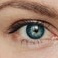

In [ ]:
Im.open(train_data.filepaths[1])

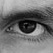

In [ ]:
Im.open(train_data.filepaths[0])

In [ ]:
data = [] # initialize an empty numpy array
image_size = 100 # image size taken is 100 here. one can take other size too
for i in range(len(train_data)):

  img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE) # converting the image to gray scale

  new_img_array = cv2.resize(img_array, (image_size, image_size)) # resizing the image array
  data.append([new_img_array, train_data['label'][i]])
print(data[:2])

[[array([[188, 188, 189, ..., 176, 175, 175],
       [189, 189, 188, ..., 174, 173, 172],
       [190, 189, 188, ..., 168, 167, 167],
       ...,
       [133, 137, 144, ..., 168, 167, 166],
       [134, 138, 145, ..., 165, 164, 163],
       [135, 139, 146, ..., 163, 162, 162]], dtype=uint8), 'male'], [array([[167, 169, 173, ..., 194, 195, 195],
       [168, 170, 173, ..., 193, 194, 195],
       [171, 171, 173, ..., 192, 193, 194],
       ...,
       [183, 185, 189, ..., 199, 197, 196],
       [183, 186, 189, ..., 199, 197, 195],
       [184, 186, 190, ..., 199, 196, 195]], dtype=uint8), 'female']]


In [ ]:
image_copy = np.copy(data)
size_x, size_y = image_copy.shape

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


In [ ]:
size_x, size_y


(9220, 2)

# Data Pre-processing
It is necessary to bring all the images in the same shape and size, also convert them to their pixel values because all machine learning or deep learning models accepts only the numerical data. Also we need to convert all the labels from categorical to numerical values.

In [ ]:
def import_data(labels_ = "/content/content/eye_gender_data/Training_set.csv",
                files_ = '/content/content/eye_gender_data/train/',
                train_data_ =True):
  labels = pd.read_csv(labels_) # loading the labels
  file_paths = [[fname, files_ + fname] for fname in labels['filename']]
  train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
  data = [] # initialize an empty numpy array
  image_size = 100 # image size taken is 100 here. one can take other size too
  for i in range(len(train_data)):

    img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE) # converting the image to gray scale

    new_img_array = cv2.resize(img_array, (image_size, image_size)) # resizing the image array
    if train_data_ == True:
      data.append([new_img_array, train_data['label'][i]])
    else:
      data.append([new_img_array])
    X = np.squeeze(data)
  return X


def preprocess_img(X, train_data_ = True, proportion=0.2, random_state=None):
  n = len(X)
  for i in range(len(X)):
   X[i][0] = X[i][0]/255.
  
  if train_data_ == True :
    x_train = np.array([X[i][0] for i in range(len(X))]).reshape((n,100,100,1))
    y_train = [X[i][1] for i in range(len(X))]
    y_train_coded = np.array([1 if i=='male' else 0 for i in y_train])
    y_train_coded.reshape(n,1)
    return train_test_split(x_train, y_train_coded,
                            test_size=proportion,
                            random_state=random_state)
  else:
    x_test = np.array([X[i] for i in range(len(X))]).reshape((n,100,100,1))
    return x_test


In [ ]:
X = import_data()
x_train,  x_validate, y_train, y_validate = preprocess_img(X)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# Building Model & Hyperparameter tuning
Now we are finally ready, and we can train the model.

In [ ]:
# define input shape
INPUT_SHAPE = (100, 100, 1)

# define sequential model
model = keras.models.Sequential()
# define conv-pool layers - set 1
model.add(layers.Conv2D(filters=10, kernel_size=(3, 3), strides=(1, 1),
activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
model.add(layers.Conv2D(filters=10, kernel_size=(2, 2), strides=(1, 1),
activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))


# add flatten layer
model.add(layers.Flatten())

# add dense layers with some dropout
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.3))


# add output layer
model.add(layers.Dense(1, activation='sigmoid'))

# compile model
model.compile(optimizer='adam',
loss='BinaryCrossentropy',
metrics=['accuracy','AUC'])

# view model layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 98, 98, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 10)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 10)        410       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5760)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1474816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

# Validate the model

In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=15, verbose=1, 
        shuffle=True, validation_data = (x_validate,y_validate),
        use_multiprocessing=True)

Epoch 1/15
231/231 [==============================] - 41s 159ms/step - loss: 0.6285 - accuracy: 0.6316 - auc: 0.6689 - val_loss: 0.4180 - val_accuracy: 0.8102 - val_auc: 0.8954
Epoch 2/15
231/231 [==============================] - 35s 149ms/step - loss: 0.4229 - accuracy: 0.8141 - auc: 0.8856 - val_loss: 0.3186 - val_accuracy: 0.8644 - val_auc: 0.9399
Epoch 3/15
231/231 [==============================] - 35s 151ms/step - loss: 0.3340 - accuracy: 0.8621 - auc: 0.9296 - val_loss: 0.2862 - val_accuracy: 0.8834 - val_auc: 0.9511
Epoch 4/15
231/231 [==============================] - 35s 150ms/step - loss: 0.2963 - accuracy: 0.8783 - auc: 0.9450 - val_loss: 0.2700 - val_accuracy: 0.8850 - val_auc: 0.9576
Epoch 5/15
231/231 [==============================] - 35s 151ms/step - loss: 0.2673 - accuracy: 0.8853 - auc: 0.9558 - val_loss: 0.2376 - val_accuracy: 0.9062 - val_auc: 0.9649
Epoch 6/15
231/231 [==============================] - 35s 151ms/step - loss: 0.2266 - accuracy: 0.9077 - auc: 0.967

# Predict The Output For Testing Dataset 😅
We have trained our model, evaluated it and now finally we will predict the output/target for the testing data (i.e. Test.csv).

Load Test Set
Load the test data on which final submission is to be made.



In [ ]:
X_test = import_data(labels_="/content/content/eye_gender_data/Testing_set.csv", 
                     files_='/content/content/eye_gender_data/test/', train_data_=False)

In [ ]:
X_test

array([[  0,   0,   0, ...,   0,   0,   0],
       [178, 180, 178, ...,  92, 108, 121],
       [177, 177, 175, ...,  69,  85,  98],
       ...,
       [153, 156, 158, ..., 188, 189, 189],
       [152, 154, 157, ..., 188, 189, 190],
       [150, 153, 156, ..., 189, 190, 191]], dtype=uint8)

# Data Pre-processing on test_data


In [ ]:
x_test = preprocess_img(X_test, train_data_=False)

# Make Prediction on Test Dataset
Time to make a submission!!!

In [ ]:
prediction_code = model.predict(x_test)
predictions = np.array(['male' if i==1 else 'female' for i in prediction_code])
predictions[1:5]

array(['female', 'male', 'female', 'male'], dtype='<U6')

# save prediction results locally via colab notebook
 A file named 'prediction_results' will be downloaded in my system.

In [ ]:
# To create Dataframe of predicted value with particular respective index
res = pd.DataFrame(predictions) #preditcions are nothing but the final predictions of your model on input features of your new unseen test data
res.columns = ["label"]

# To download the csv file locally
# from google.colab import files
res.to_csv('prediction_results.csv', index = False)         
files.download('prediction_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# conclusion
It was amazing journey with deep learning. I learnt lot about deep learning on image dataset to determine gender using eye detector. I have run few epochs for validation and found good result. 